In [58]:
import numpy as np
import os 
import pandas as pd

In [59]:
s = os.path.join('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
df = pd.read_csv(s, header = None, encoding = 'utf-8')
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [60]:
y = df.iloc[0:100, 4].values    # 세토사와 버시컬러 두 개만
y = np.where(y == 'Iris-setosa', -1 , 1)

In [61]:
X = df.iloc[0:100, [0,2]].values

In [62]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [63]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, clf, res = 0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:,1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, res),
                          np.arange(x2_min, x2_max, res))
    
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = .3, cmap = cmap)
    
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                   y = X[y == cl, 1],
                   alpha = .8, c = colors[idx], marker = markers[idx], label = cl, edgecolor = 'black')

In [64]:
class AdalineSGD(object):
    '''
    Parameter
    ------
    eta: 학습률
    n_iter: 훈련 데이터셋 반복 횟수
    
    Attributes
    ------
    w_ : 학습된 가중치
    cost_ : 모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합
    '''
    def __init__(self, eta = .01, n_iter = 10, shuffle = True, random_state = None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        '''
        훈련 데이터 학습
        Parameter
        -------
        X: 훈련 데이터
        y: 타깃 벡터
        
        반환값
        -------
        self: object
        '''
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc = 0.0, scale = 0.01, size = 1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

<ipython-input-63-86ebed550b35>:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x = X[y == cl, 0],


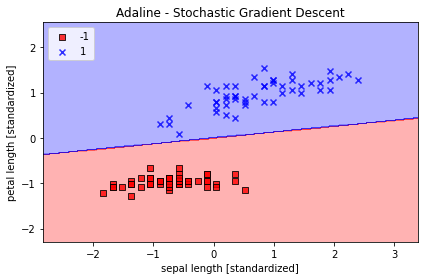

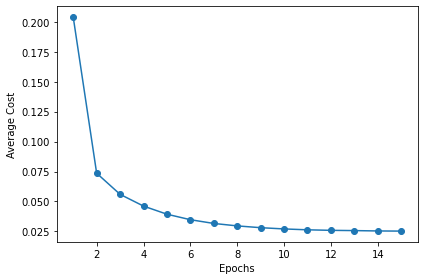

In [65]:
ada_sgd = AdalineSGD(n_iter = 15, eta = 0.01, random_state = 1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, clf = ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()

In [66]:
ada_sgd.partial_fit(X_std[0, :], y[0])